In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split

from source.config import *
from source.utils.analysis_helper import load_groups_of_interest
from source.stability.batch_stability_analyzer import BatchStabilityAnalyzer
from source.stability.stability_fairness_analyzer import StabilityFairnessAnalyzer

In [4]:
sns.set(rc={'figure.figsize':(15, 5)})
dataset_name = 'folktables'
state = 'LA'
extended_dataset_name = f"{dataset_name}_{state}"
dataset_config = DATASETS_CONFIG[dataset_name]
TARGET_COLUMN = dataset_config['target_column']

In [5]:
# Creating a data frame
df = pd.read_csv(f"../../datasets/folktables-{state}-2018.csv", delimiter=',')
df.head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,29,18,5,16,2,0,1,1,4,2,1,2,2,2,1,1,0
1,17,13,5,16,2,0,1,1,4,1,1,2,2,2,1,2,0
2,37,13,5,16,2,0,1,1,4,1,1,2,2,2,1,1,0
3,86,12,2,16,1,0,1,1,4,1,1,2,1,2,2,2,0
4,22,19,5,17,2,0,1,1,4,1,1,2,2,2,2,1,0


In [6]:
df.shape

(43588, 17)

In [7]:
df.columns

Index(['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC',
       'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR'],
      dtype='object')

In [8]:
df['ESR'].value_counts()

0    25363
1    18225
Name: ESR, dtype: int64

In [9]:
numerical_features = dataset_config['numerical_features']
categorical_features = [feature for feature in df.columns if feature not in numerical_features + [TARGET_COLUMN]]

categorical_features

['MAR',
 'RELP',
 'DIS',
 'ESP',
 'CIT',
 'MIG',
 'MIL',
 'ANC',
 'NATIVITY',
 'DEAR',
 'DEYE',
 'DREM',
 'SEX',
 'RAC1P']

### Apply data transformations

In [10]:
from sklearn.preprocessing import StandardScaler
from source.utils.simple_utils import make_feature_df


def transform_df(df, categorical_columns, numerical_columns):
    dataset_size = df.shape[0]
    test_size = int(TEST_FRACTION * dataset_size)
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=SEED)

    X_test_df = test_df.drop([TARGET_COLUMN], axis=1)
    test_groups = load_groups_of_interest(group_info=TEST_GROUPS_CONFIG['folktables'], X_test_df=X_test_df)

    train_feature_df = make_feature_df(train_df, categorical_columns, numerical_columns)
    test_feature_df = make_feature_df(test_df, categorical_columns, numerical_columns)

    scaler = StandardScaler()
    train_feature_df[train_feature_df.columns] = scaler.fit_transform(train_feature_df[train_feature_df.columns])
    test_feature_df[test_feature_df.columns] = scaler.transform(test_feature_df[test_feature_df.columns])

    train_feature_df[TARGET_COLUMN] = train_df[TARGET_COLUMN]
    test_feature_df[TARGET_COLUMN] = test_df[TARGET_COLUMN]
    print("train_feature_df shape: ", train_feature_df.shape)
    print("test_feature_df shape: ", test_feature_df.shape)

    return train_feature_df, test_feature_df, test_groups


In [11]:
train_df, test_df, test_groups = transform_df(df, categorical_features, numerical_features)

train_feature_df shape:  (34871, 74)
test_feature_df shape:  (8717, 74)


### Analyze stability of Adaptive Random Forest classifier

In [12]:
from sklearn import tree


def get_evaluation_model():
    # Set hyper-parameters for the best model. Use hyper-parameters, which were tuned on a drop-column dataset
    model_name = 'DecisionTreeClassifier'

    return model_name, tree.DecisionTreeClassifier(
                            criterion='entropy',
                            max_depth=10,
                            max_features=0.6
                        )

In [13]:
y_train = train_df[TARGET_COLUMN]
X_train = train_df.drop([TARGET_COLUMN], axis=1)

In [14]:
base_model_name, base_model = get_evaluation_model()

In [15]:
stability_analyzer =  BatchStabilityAnalyzer(base_model,
                                             base_model_name=base_model_name,
                                             train_pd_dataset=train_df,
                                             test_pd_dataset=test_df,
                                             test_y_true=test_df[TARGET_COLUMN],
                                             dataset_name=dataset_name + '_LA',
                                             target_column=TARGET_COLUMN,
                                             n_estimators=200)

stability_fairness_analyzer = StabilityFairnessAnalyzer(stability_analyzer, test_groups)

2022-11-29 16:26:48 base_stability_analyzer.py INFO    : Start testing of classifier 1 / 200
2022-11-29 16:26:48 base_stability_analyzer.py INFO    : Classifier 1 / 200 was tested
2022-11-29 16:26:48 base_stability_analyzer.py INFO    : Start testing of classifier 2 / 200
2022-11-29 16:26:48 base_stability_analyzer.py INFO    : Classifier 2 / 200 was tested
2022-11-29 16:26:48 base_stability_analyzer.py INFO    : Start testing of classifier 3 / 200
2022-11-29 16:26:48 base_stability_analyzer.py INFO    : Classifier 3 / 200 was tested
2022-11-29 16:26:48 base_stability_analyzer.py INFO    : Start testing of classifier 4 / 200
2022-11-29 16:26:48 base_stability_analyzer.py INFO    : Classifier 4 / 200 was tested
2022-11-29 16:26:48 base_stability_analyzer.py INFO    : Start testing of classifier 5 / 200
2022-11-29 16:26:48 base_stability_analyzer.py INFO    : Classifier 5 / 200 was tested
2022-11-29 16:26:48 base_stability_analyzer.py INFO    : Start testing of classifier 6 / 200
2022-11

results.shape --  (200, 8717)
uq_labels.shape --  (200, 8717)


2022-11-29 16:28:44 base_stability_analyzer.py INFO    : Successfully computed predict proba metrics
2022-11-29 16:28:47 base_stability_analyzer.py INFO    : Successfully computed predict labels metrics




##############################  Stability metrics  ##############################
General Ensemble Accuracy: 0.8159
Mean: 0.5844
Std: 0.0792
IQR: 0.0914
Entropy: 0.1175
Jitter: 0.0718
Per sample accuracy: 0.8067
Label stability: 0.9008




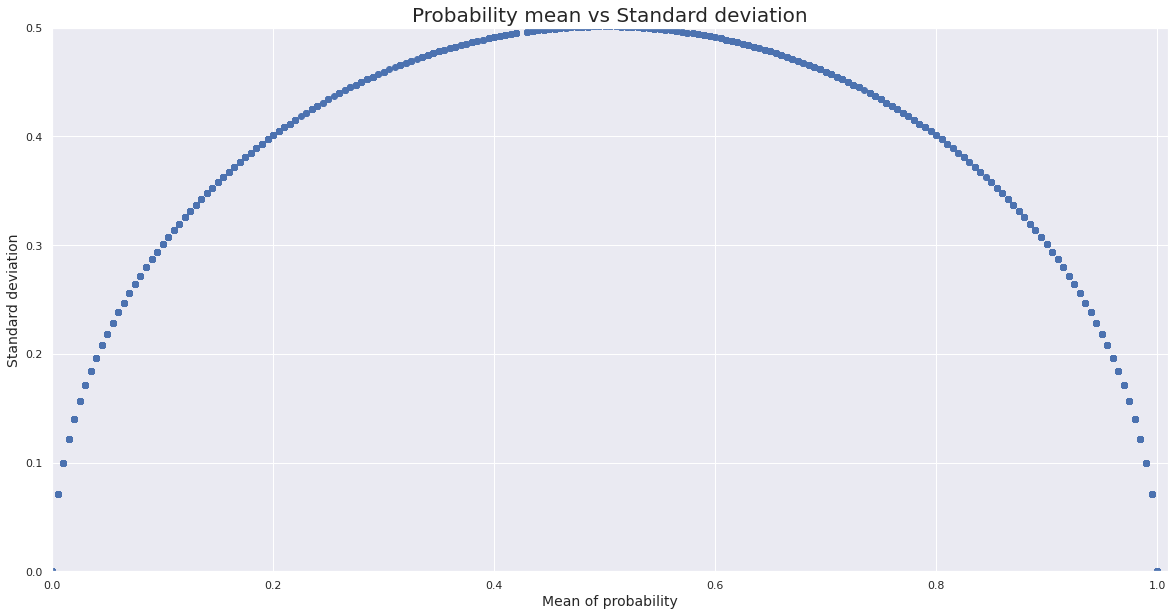

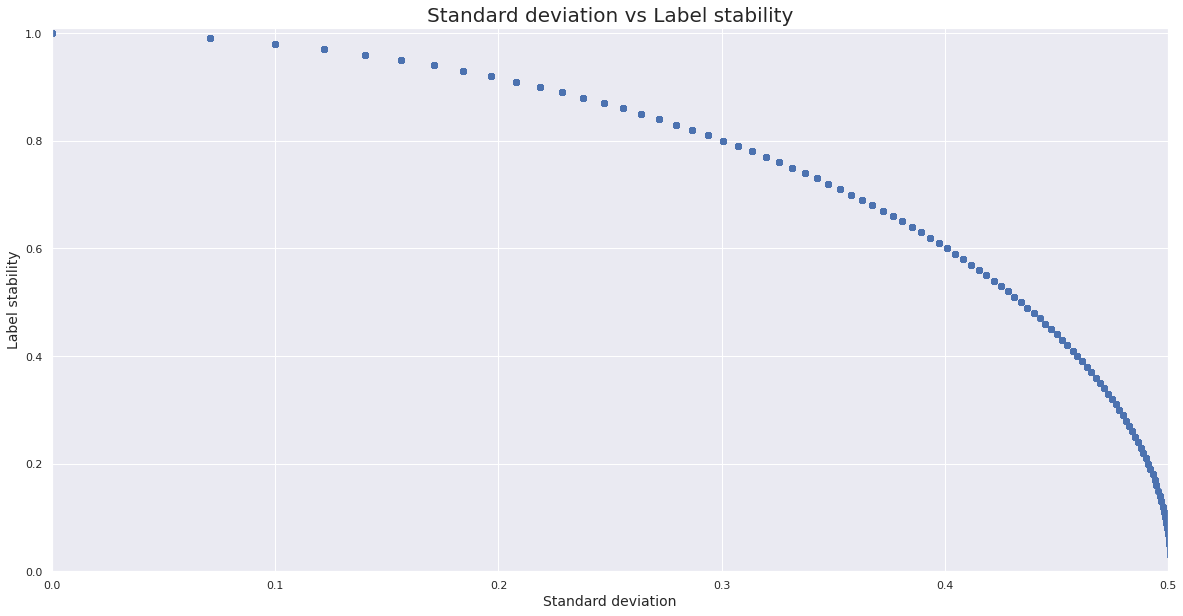

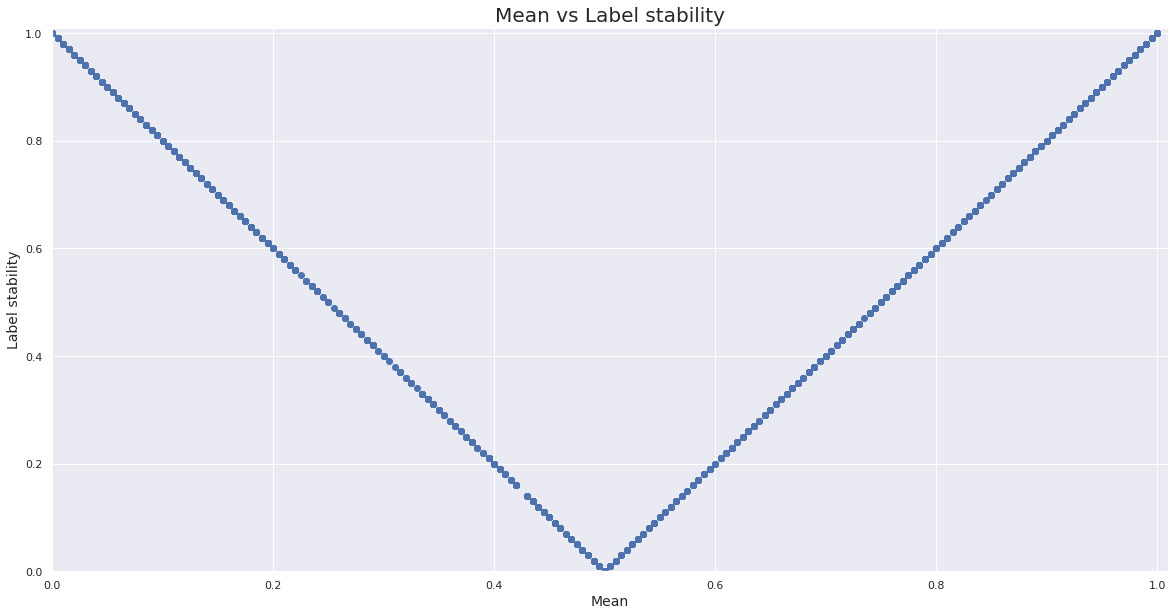

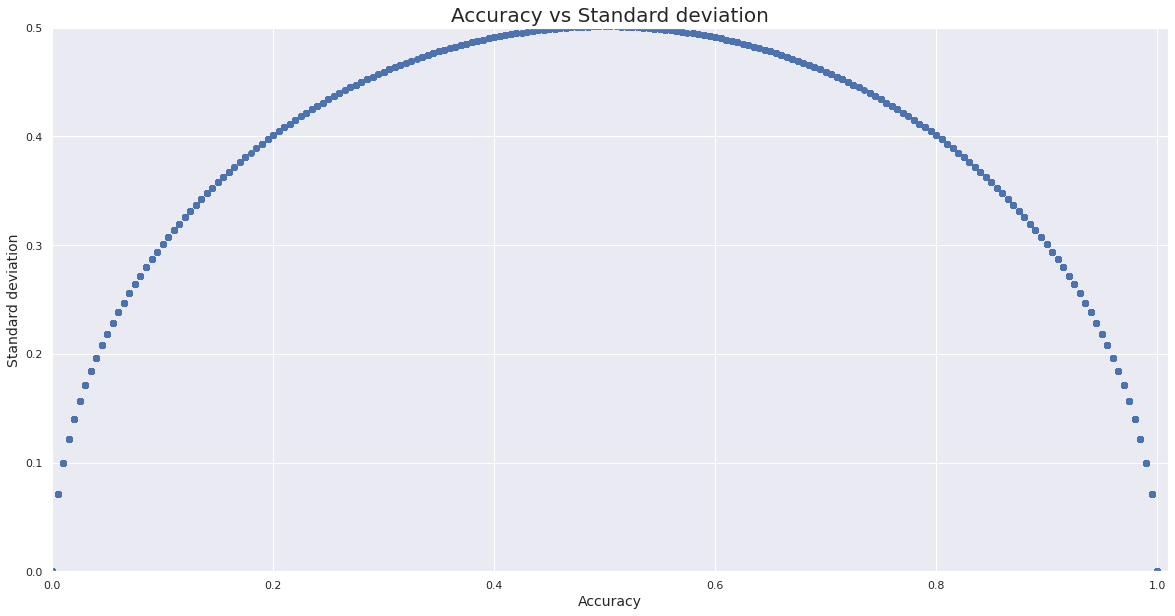

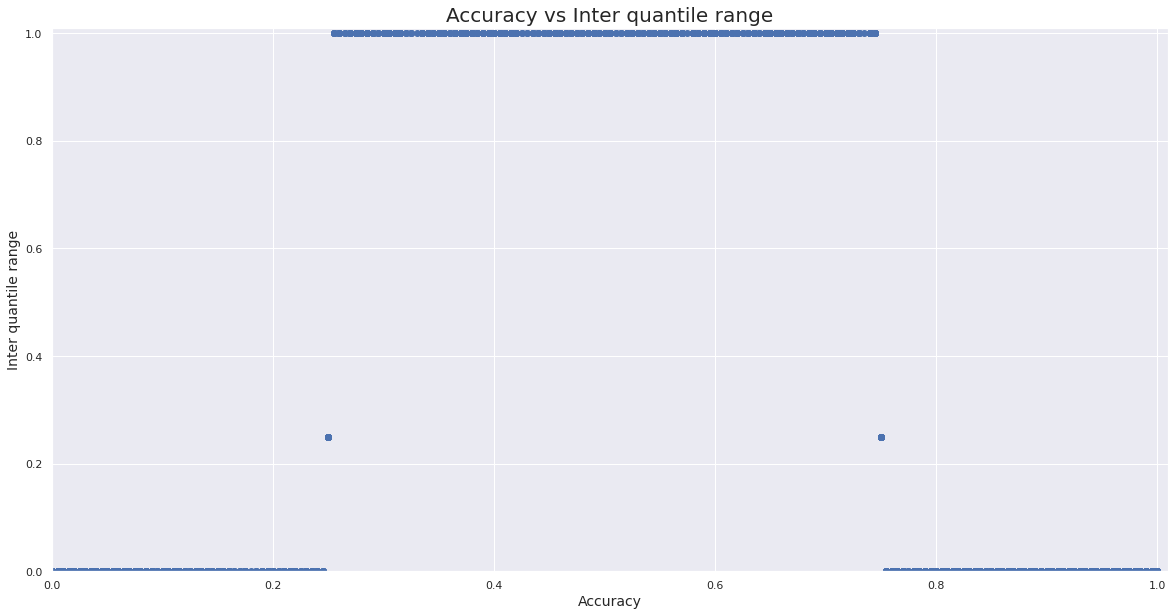



##############################  Fairness metrics  ##############################

#################### Accuracy ####################
            Race     Sex  Race_Sex
adv       0.8154  0.8413    0.8380
disadv    0.8127  0.7914    0.7902
Accuracy  0.0028  0.0499    0.0478

#################### Disparate_Impact ####################
                    Race     Sex  Race_Sex
adv               0.4851  0.4570    0.4884
disadv            0.4282  0.4792    0.4705
Disparate_Impact  0.8827  1.0485    0.9633

#################### Equal_Opportunity ####################
                     Race     Sex  Race_Sex
adv                0.8448  0.8537    0.8500
disadv             0.8478  0.8387    0.8427
Equal_Opportunity -0.0030  0.0150    0.0074

#################### Statistical_Parity_Difference ####################
                                 Race     Sex  Race_Sex
adv                            1.1129  1.0837    1.0475
disadv                         1.2364  1.1997    1.2371
Statistical_Par

In [16]:
stability_fairness_analyzer.measure_metrics(make_plots=True)